# 군집별 항로 학습

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt
import os

## 하이퍼 파라미터 설정

In [15]:
CLUSTER_ID = 2
PAST_HORIZON = 18      # 3시간 입력
FUTURE_TARGET = 36     # 6시간 후 예측
EPOCHS = 30
BATCH_SIZE = 32
MODEL_SAVE_PATH = f"cluster_{CLUSTER_ID}_step_4vars.keras"

## 데이터 로딩 및 정제

In [5]:
df = pd.read_csv(f'./dataset/cluster1_2.csv', parse_dates=['TIMESTAMP']) # parse_dates=['TIMESTAMP'] : CSV 파일을 읽을 때 특정 열을 "날짜/시간(datetime) = datetime64" 형식으로 자동 변환
df = df.sort_values('TIMESTAMP')

In [7]:
features = ['LAT', 'LON', 'COG', 'HEADING']
df = df.dropna(subset=features)

## 스케일링

In [9]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features])
df_scaled = pd.DataFrame(scaled_features, columns=features)
df_scaled['TIMESTAMP'] = df['TIMESTAMP'].values

## 시퀀스 함수 생성 -> 입력값 4개 예측

In [11]:
def create_sequences(data, past_horizon, future_target):
    X, y, ref_points = [], [], []
    for i in range(len(data) - past_horizon - future_target):
        x_seq = data[i:i+past_horizon]
        y_target = data[i+past_horizon+future_target-1]  # LAT, LON, COG, HEADING
        ref = data[i+past_horizon-1]
        X.append(x_seq)
        y.append(y_target)
        ref_points.append(ref)
    return np.array(X), np.array(y), np.array(ref_points)

# 시퀀스 생성

In [17]:
sequence_data = df_scaled[features].values
X, y, ref_points = create_sequences(sequence_data, PAST_HORIZON, FUTURE_TARGET)

## LSTM 모델 구성

In [21]:
inputs = Input(shape=(PAST_HORIZON, len(features)))
x = LSTM(64)(inputs)
x = Dense(32, activation='relu')(x) # layer 쌓을 때 x = 하고 쌓으면 됨
outputs = Dense(4)(x)  # LAT, LON, COG, HEADING 모두 예측
model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 18, 4)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,876 (77.64 KB)

 Trainable params: 19,876 (77.64 KB)

 Non-trainable params: 0 (0.00 B)

## 모델 학습

In [23]:
history = model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Epoch 1/30
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.0478 - val_loss: 0.0473
Epoch 2/30
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0377 - val_loss: 0.0517
Epoch 3/30
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0375 - val_loss: 0.0503
Epoch 4/30
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0369 - val_loss: 0.0493
Epoch 5/30
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0366 - val_loss: 0.0494
Epoch 6/30
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0363 - val_loss: 0.0480
Epoch 7/30
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0360 - val_loss: 0.0477
Epoch 8/30
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0355 - val_loss: 0.0496
Epoch 9/30
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0357 - val_loss: 0.0509
Epoch 10/30
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0354 - val_loss: 0.0511
Epoch 11/30
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0353 - val_loss: 0.0493
Epoch 12

## 모델 저장

In [26]:
os.makedirs('./saved_models', exist_ok=True)
model.save(f'./saved_models/{MODEL_SAVE_PATH}')
print(f"모델 저장 완료: {MODEL_SAVE_PATH}")

모델 저장 완료: cluster_2_step_4vars.keras


## 예측

In [28]:
y_pred = model.predict(X)

1362/1362 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step


## 역정규화
- 예측한 결과를 원래의 스케일(단위)로 되돌리는 작업
- 머신러닝 학습 전에 입력값과 출력값을 0 ~ 1 사이의 범위로 정규화 -> 그 상태에서 모델이 예측한 값도 정규화된 값이기 때문에, 실제 의미 있는 값(LAT, LON, COG, HEADING)으로 해석하려면 원래 단위로 되돌려야 함

In [30]:
y_pred_real = scaler.inverse_transform(y_pred)
y_actual_real = scaler.inverse_transform(y)
ref_points_real = scaler.inverse_transform(ref_points)

## 예측 결과 출력
- 각기 다른 시점(또는 선박 구간)에 대해, 과거 3시간의 항로 데이터를 기반으로 6시간 뒤의 위치(LAT, LON)와 방향(COG, HEADING)을 예측했고, 그 결과를 실제 위치/방향(CSV 파일)과 비교한 것임.
- 데이터가 여러 선박으로 구성되어 있다면 -> 여러 선박의 예측이 함께 섞여 있는 것
- 여러 시점 또는 여러 선박의 예측 결과를 순차적으로 보여준 것

In [32]:
print("예측 결과 vs 실제 결과 (일부 샘플)\n")
for i in range(5):
    print(f"[{i+1}]")
    print(f"예측 LAT, LON     : {y_pred_real[i][:2]}")
    print(f"예측 COG, HEADING : {y_pred_real[i][2:]}")
    print(f"실제 LAT, LON     : {y_actual_real[i][:2]}")
    print(f"실제 COG, HEADING : {y_actual_real[i][2:]}")
    print("-" * 50)

예측 결과 vs 실제 결과 (일부 샘플)

[1]
예측 LAT, LON     : [ 33.642    127.704346]
예측 COG, HEADING : [229.15173 235.72609]
실제 LAT, LON     : [ 33.41777618 127.34803059]
실제 COG, HEADING : [230.35294118 230.35294118]
--------------------------------------------------
[2]
예측 LAT, LON     : [ 33.5934 127.6436]
예측 COG, HEADING : [231.07481 237.12811]
실제 LAT, LON     : [ 33.39295676 127.30595088]
실제 COG, HEADING : [230.52941176 230.52941176]
--------------------------------------------------
[3]
예측 LAT, LON     : [ 33.541832 127.56978 ]
예측 COG, HEADING : [232.89143 238.90916]
실제 LAT, LON     : [ 33.36813735 127.26387118]
실제 COG, HEADING : [230.70588235 230.70588235]
--------------------------------------------------
[4]
예측 LAT, LON     : [ 33.496975 127.501785]
예측 COG, HEADING : [234.23442 240.6216 ]
실제 LAT, LON     : [ 33.34331794 127.22179147]
실제 COG, HEADING : [230.88235294 230.88235294]
--------------------------------------------------
[5]
예측 LAT, LON     : [ 33.459415 127.44593 ]
예측 COG, HEADING : 

## 학습 시각화

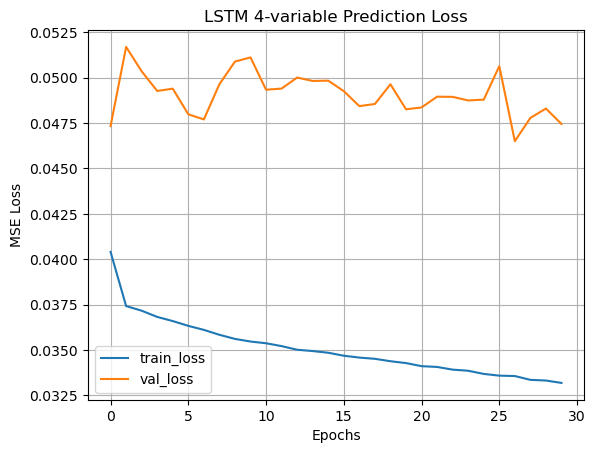

In [34]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('LSTM 4-variable Prediction Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid()
plt.show()

# 다른 선박 대입

In [36]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

## 하이퍼 파라미터 설정

In [50]:
PAST_HORIZON = 18           # 입력 구간 길이 (ex: 3시간 = 18개 시점)
FUTURE_TARGET = 36          # 예측 목표 시점 (ex: 6시간 후 = 36개 시점)
MODEL_PATH = './saved_models/cluster_2_step_4vars.keras'  # 모델 파일

## 데이터 불러기기

In [38]:
ship_path = './dataset/CNSHA/06724e0f-5a08-3aa8-b42c-97acf4f8102d.csv'
new_df = pd.read_csv(ship_path, parse_dates=['TIMESTAMP'])
new_df = new_df.sort_values('TIMESTAMP')

## 전처리

In [40]:
features = ['LAT', 'LON', 'COG', 'HEADING']
new_df = new_df.dropna(subset=features)

## 학습하기

In [42]:
scaler = MinMaxScaler()
scaler.fit(new_df[features])  # 실제론 학습 데이터 기준으로 해야 더 정확함

scaled_features = scaler.transform(new_df[features])
new_df_scaled = pd.DataFrame(scaled_features, columns=features)
new_df_scaled['TIMESTAMP'] = new_df['TIMESTAMP'].values

## 시퀀스 생성 함수

In [46]:
def create_sequences(data, past_horizon, future_target):
    X, y_real, ref_points = [], [], []
    for i in range(len(data) - past_horizon - future_target):
        x_seq = data[i:i+past_horizon]
        y_true = data[i+past_horizon+future_target-1]
        ref = data[i+past_horizon-1]
        X.append(x_seq)
        y_real.append(y_true)
        ref_points.append(ref)
    return np.array(X), np.array(y_real), np.array(ref_points)

sequence_data = new_df_scaled[features].values
X_new, y_real_scaled, ref_scaled = create_sequences(sequence_data, PAST_HORIZON, FUTURE_TARGET)

## 모델 불러오기 및 예측

In [52]:
model = load_model(MODEL_PATH)
y_pred_scaled = model.predict(X_new)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


## 역정규화

In [54]:
y_pred_real = scaler.inverse_transform(y_pred_scaled)
y_real_true = scaler.inverse_transform(y_real_scaled)
ref_real = scaler.inverse_transform(ref_scaled)

## 예측 결과 출력

In [64]:
print("새 선박 예측 결과 (일부)\n")
for i in range(5):
    print(f"[{i+1}]")
    print(f"예측 LAT, LON     : {y_pred_real[i][:2]}")
    print(f"예측 COG, HEADING : {y_pred_real[i][2:]}")
    print(f"실제 LAT, LON     : {y_real_true[i][:2]}")
    print(f"실제 COG, HEADING : {y_real_true[i][2:]}")
    print("-" * 50)

새 선박 예측 결과 (일부)

[1]
예측 LAT, LON     : [ 34.041157 128.13132 ]
예측 COG, HEADING : [241.1961  246.61375]
실제 LAT, LON     : [ 33.5152  127.76535]
실제 COG, HEADING : [232. 234.]
--------------------------------------------------
[2]
예측 LAT, LON     : [ 34.01193 128.1197 ]
예측 COG, HEADING : [242.06197 246.85426]
실제 LAT, LON     : [ 33.50086667 127.7435    ]
실제 COG, HEADING : [231.5 234. ]
--------------------------------------------------
[3]
예측 LAT, LON     : [ 33.984276 128.08405 ]
예측 COG, HEADING : [241.92798 246.77692]
실제 LAT, LON     : [ 33.48653333 127.72165   ]
실제 COG, HEADING : [231. 234.]
--------------------------------------------------
[4]
예측 LAT, LON     : [ 33.956154 128.05396 ]
예측 COG, HEADING : [241.95169 246.84248]
실제 LAT, LON     : [ 33.4575     127.67798333]
실제 COG, HEADING : [231. 234.]
--------------------------------------------------
[5]
예측 LAT, LON     : [ 33.928284 128.02199 ]
예측 COG, HEADING : [241.81888 246.90459]
실제 LAT, LON     : [ 33.43816111 127.64849444]
실제 CO

## 예측 결과 시각화

In [60]:
import folium

# 중심 좌표 설정: 기준 시점의 첫 번째 위치 (LAT, LON만 사용)
center = ref_points_real[0][:2]
m = folium.Map(location=center, zoom_start=6)

# 전체 실제 항로 궤적 (선박 전체 움직임 시각화용 - 선택)
latlon_data = df[['LAT', 'LON']].values
folium.PolyLine(locations=latlon_data.tolist(), color='blue', weight=2, popup='전체 실제 항로').add_to(m)

# 시각화 인덱스 범위 제한 (길이 차이 방지 + 성능)
N = min(len(ref_points_real), len(y_pred_real), len(y_actual_real))

# 시각화 간격 설정 (예: 10개 단위로만 표시)
for i in range(0, N, 10):
    # 주황 - 기준 시점 (3시간 입력 시점)
    lat, lon, cog, head = ref_points_real[i]
    folium.CircleMarker(
        location=[lat, lon],
        radius=4,
        color='orange',
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(
            f"<b>기준 시점 (3시간)</b><br>LAT: {lat:.5f}<br>LON: {lon:.5f}<br>COG: {cog:.1f}°<br>HEADING: {head:.1f}°",
            max_width=250
        )
    ).add_to(m)

    # 빨강 - 예측 위치 (6시간 뒤)
    lat, lon, cog, head = y_pred_real[i]
    folium.CircleMarker(
        location=[lat, lon],
        radius=4,
        color='red',
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(
            f"<b>예측 위치 (6시간)</b><br>LAT: {lat:.5f}<br>LON: {lon:.5f}<br>COG: {cog:.1f}°<br>HEADING: {head:.1f}°",
            max_width=250
        )
    ).add_to(m)

    # 파랑 - 실제 위치 (6시간 실제 값)
    lat, lon, cog, head = y_actual_real[i]
    folium.CircleMarker(
        location=[lat, lon],
        radius=4,
        color='blue',
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(
            f"<b>실제 위치 (6시간)</b><br>LAT: {lat:.5f}<br>LON: {lon:.5f}<br>COG: {cog:.1f}°<br>HEADING: {head:.1f}°",
            max_width=250
        )
    ).add_to(m)

    # 기준 → 예측 연결선
    folium.PolyLine(
        locations=[
            ref_points_real[i][:2].tolist(),
            y_pred_real[i][:2].tolist()
        ],
        color='gray',
        weight=1,
        dash_array='5,5',
        popup='예측 이동 방향'
    ).add_to(m)

# 지도 표시
display(m)
